# YOLOv3

YOLOv3 is one of the fastest object detection and recognitions algorithms in the field, relying largely on convolutional neural networks. It is in an improved iteration over its predecessors, YOLO and YOLOv2, featuring multiscale detection, a more robust feature extraction network, as well as some minor changes in its loss function. 

In comparison to traditional recognition algorithms, YOLOv3 is able to not only predict the class labels, but also detect the locations of multiple objects in an image too. The images are passed through a single neural network, divided into different regions, and then bounding box predictions weighted by predicted region probabilities are made on the input. This makes YOLOv3 an ideal candidate for real-time inference without having to compromise on accuracy. 


# Network Architecture 

The YOLOv3 network can be broken down into two principle components, namely the multiscale feature extractor, and the detector. Images are inputted into the network, passed through the feature extractor to obtain embedded features at multiple scales, and then the extracted features are fed into the detector in order to predict the location of bounding boxes and class information. 


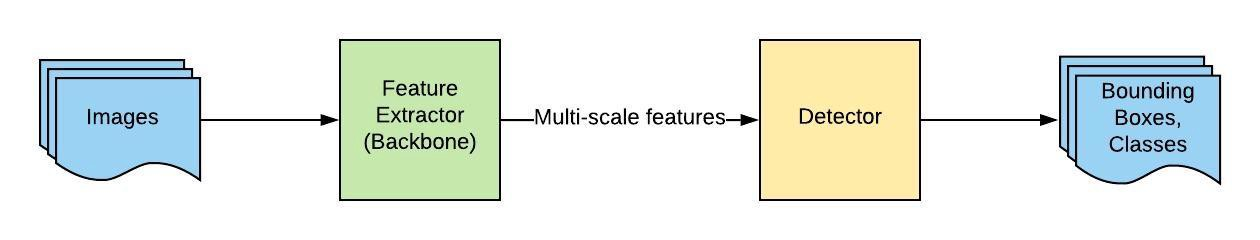

## Darknet 53

The YOLOv3 Darknet-53 feature extractor is a fully convolutional network made up of convolutional layers followed by batch normalisation layers and ReLU activations. It is an improvement on the previous implementation of Darknet-19 used in YOLO and YOLOv2, wherein Darknet-53 utilises skip connections to propagate activations through deeper layers without impacting gradients, allowing us to successfully extend the network from nineteen to fifty-three layers. This can be seen in the following diagram. 


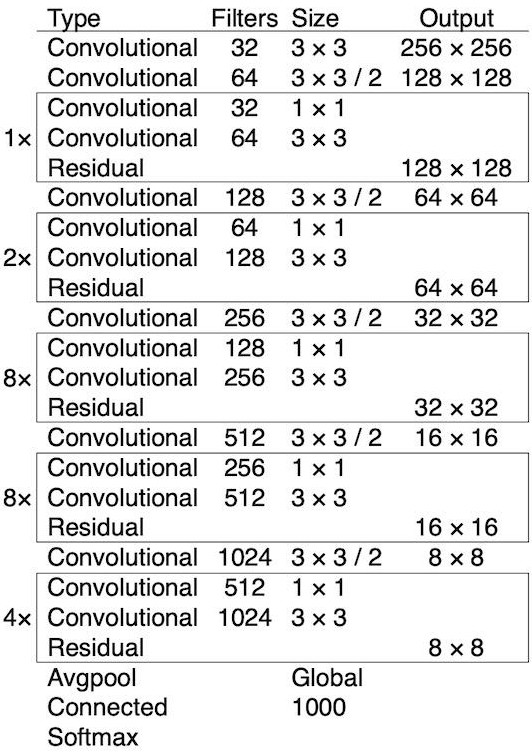

Each rectangular subsection in the diagram above can be thought of as a residual block. The entire network is simply a chain of these connected blocks with convolutional layers with a stride value of two in-between. These layers are used to downsample the feature maps by a factor of stride such as to prevent the loss of low-level features. Typically speaking, the stride of any layer in the network can be thought of as the factor by which the output of the layer is smaller than the input image to the network.


In the case of multiclass classification, the network shown above also utilises average pooling, fully-connected convolutional layers, and softmax activations. In the case of object detection, however, we instead append a detection head to the feature extractor at multiple scales. This allows us to use features from the last three residual blocks in our detection pipeline, allowing us to achieve multiscale detection and extract/detect smaller features embedding within the target image. 


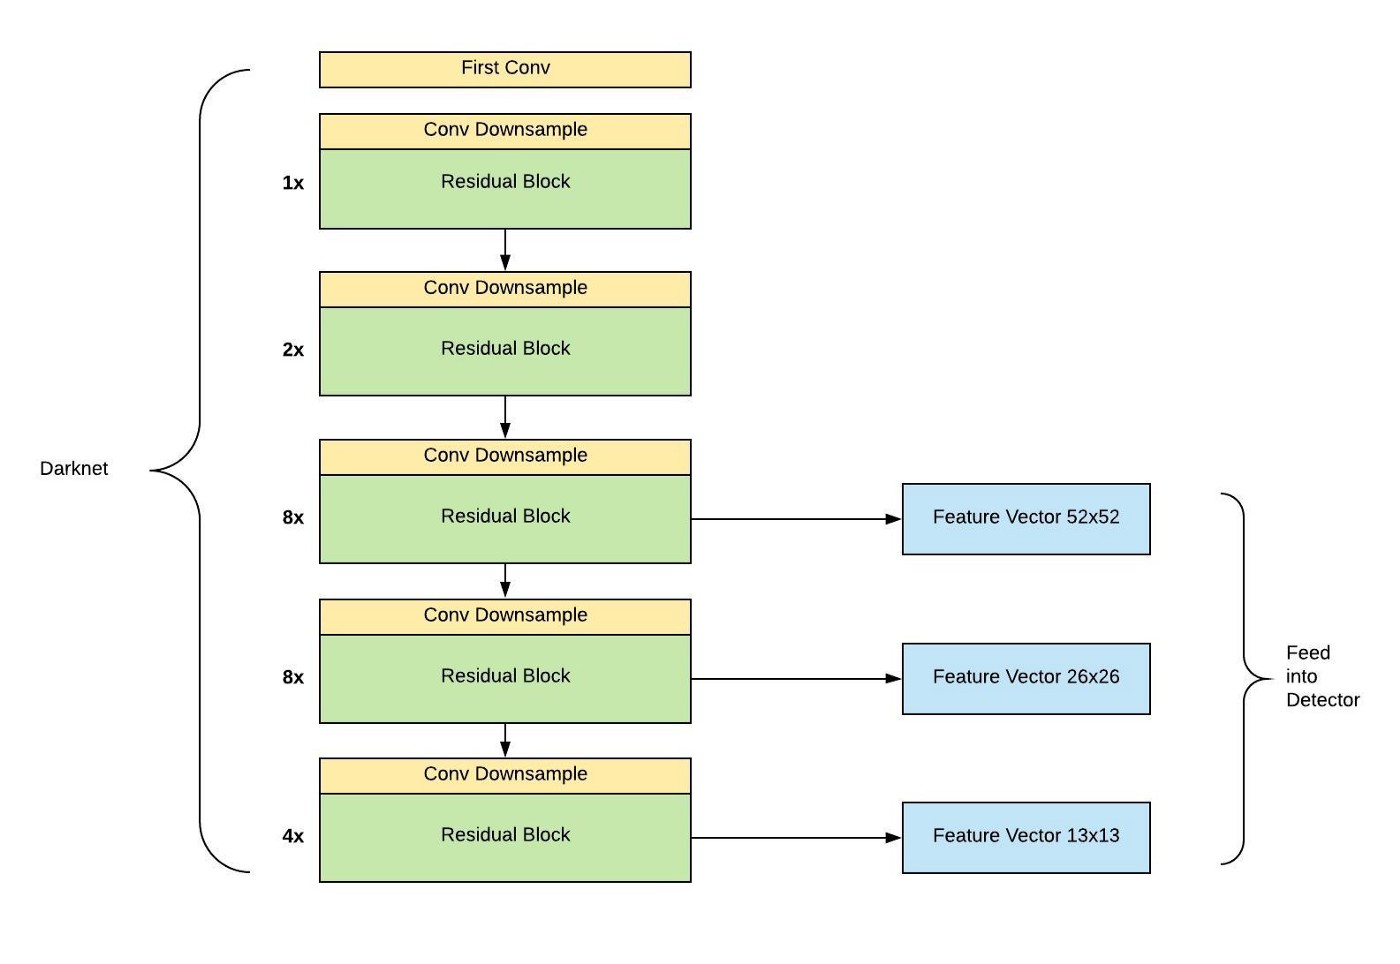

## Multiscale Detection

YOLOv3 makes predictions across multiple scales at feature maps of three different sizes, having strides 32, 16, and 8. The network downsamples the input image until the first detection layer, where a detection is made using feature maps of a layer with stride 32. Further, layers are upsampled by a factor of 2 and concatenated with feature maps of a previous layers having identical feature map sizes. Then another detection is now made at a layer with stride 16. The same upsampling procedure is repeated, and a final detection is made at the layer of stride 8. Each cell predicts 3 bounding boxes using 3 anchors for each scale. This helps YOLOv3 get better at detecting small objects as upsampling can help the network learn fine-grained features which are instrumental for detecting small objects.


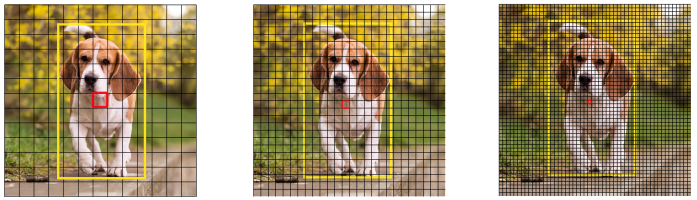

## Anchor Box

The goal of object detection is to extract bounding boxes and their corresponding class labels for objects found in a batch of input images. In order to compensate for the large variance in the scale and aspect-ratio of the boxes, we use anchor boxes to help us make predictions. In the context of object detection, an anchor box is a prior box with pre-defined aspect ratios determined prior to training. The anchor boxes are anchored to the output (square) matrix from the feature extractor, assigning anchor boxes to each cell in the grid such that they share the same centroid.  The anchor boxes allow us to then calculate the extent to which the ground truth boxes overlap with them and filter them out according to the highest IOU scores. This means that during our training, instead of predicting coordinates out of nowhere, we can instead predict offsets to the bounding boxes, along with objectness scores and class probabilities. In YOLOv3, we have three anchor boxes per grid cell, as well as three different scales. Therefore, we will have 52x52x3, 26x26x3, and 13x13x3 anchor boxes for each scale.



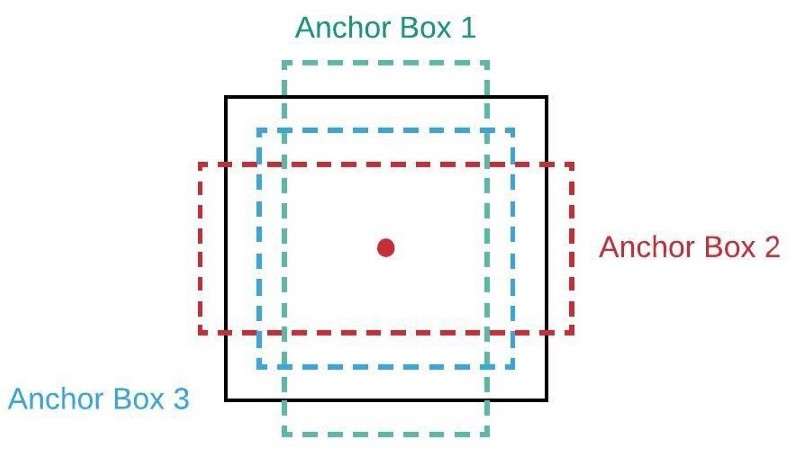

It is important to note that the objectness score simply represents the probability that an object is contained within a bounding box. It is passed through a sigmoid such that it can be interpreted as a probability. The class confidence, similarly, represents the probability of the detected object belonging to a particular class. It is also passed through a sigmoid, as opposed to a softmax function. The reason for this is that softmaxing class scores assumes that the classes are mutually exclusive. In simple words, if an object belongs to one class, then it's guaranteed it cannot belong to another class. This is true for COCO database on which we will base our detector, however, this assumptions may not hold when we have classes like man and person.


The calculated offsets mentioned above can later be applied to the anchor boxes to obtain the final prediction. The following formula describes how the network output is transformed to obtain bounding box predictions:


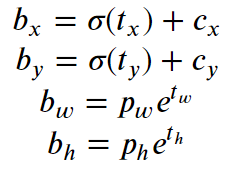

In the equations above, (𝑏𝑥, 𝑏𝑦, 𝑏𝑤, 𝑏ℎ) represent the the x and y centre coordinates, width, and height of our prediction, (𝑡𝑥, 𝑡𝑦, 𝑡𝑤, 𝑡ℎ) represent the network output/anchor box offsets, (𝑐𝑥, 𝑐𝑦) represent the top-left coordinates of the grid, and  (𝑝𝑤, 𝑝ℎ) are anchor dimensions for the box. 

It is also important to note that the centre coordinates are passed through a sigmoid function in order to force the output values within a zero-one range. This is because YOLO does not predict the absolute coordinates of the centre of the bounding box. Instead, it predicts the  offsets relative to the top left corner of the grid cell responsible for prediction and normalises them by the cell dimensions. This is to ensure that we do not break the theory behind YOLOv3. If we postulate that a certain cell is responsible for prediction and the predicted offsets are larger than one, then we end up assigning the centre to a cell that is not the predicting cell.


# Detection Output

In YOLOv3, we input a batch of images using a data loader and pass them through a feature extractor. The features learned by the convolutional layers are then passed onto a detector that makes predictions relating to the coordinates of the bounding box, class labels, and objectness scores. The output is then returned as a feature map of the same size as the feature map before it due to the use of 1x1 convolutional layers in the detection pipeline. 


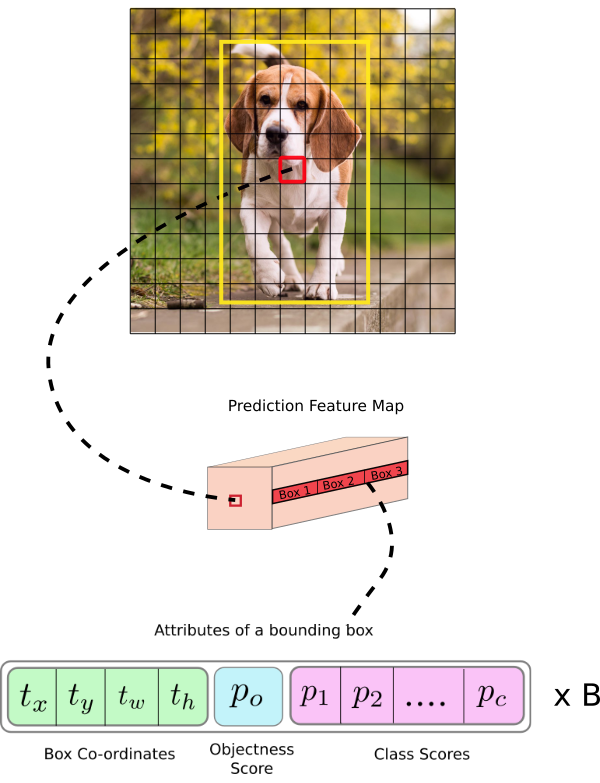

It is also important to note, as shown in the image above, that each bounding box contains 85 attributes pertaining to the boxes coordinates, the objectness score, as well as the class scores. 


In YOLOv3, we expect each cell in the feature map to predict an object through one of its three bounding boxes **iff** the centre of the object falls in the receptive field of the cell in question. This is because, during training, only one bounding box is responsible for detecting any given object. In order to achieve this, however, we must ascertain which of the cells this bounding box belongs to and so we divide input images into a grid of dimensions equal to that of the final feature map. The cell that contains the centre of the ground truth box of an object is then chosen to be the one responsible for making a prediction, and then we must determine which of that cell’s bounding boxes should be assigned to the ground truth label of the object in question based on the anchors. The bounding box responsible for detecting the dog will be the one whose anchor has the highest IoU with the ground truth box, as shown in the diagram below:

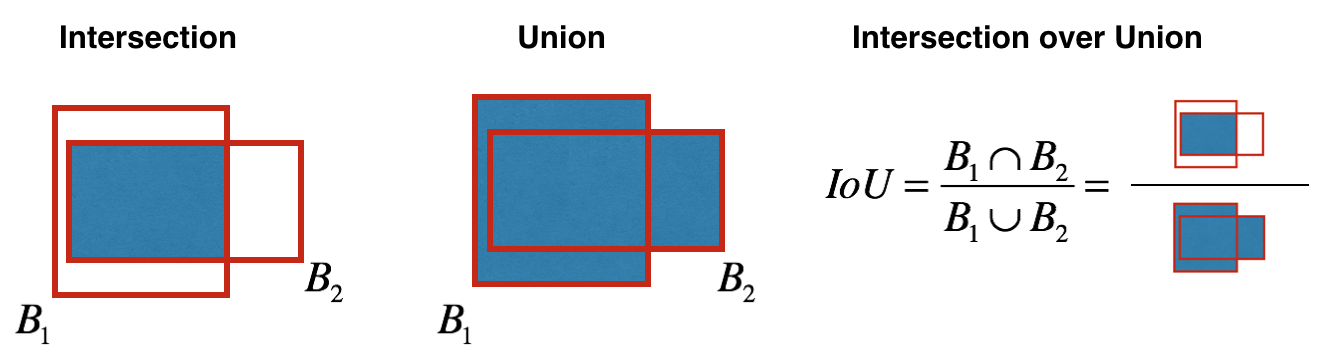

# Postprocessing

The final component of YOLOv3 is a post-processor that preforms non-maximum suppression in order to eliminate instances of multiple detections of the same object in an image.  

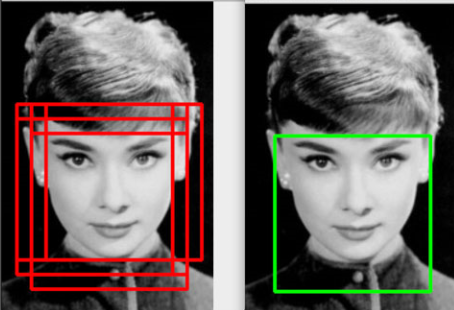

The idea being non-maximum suppression is quite simple and requires us to filter boxes based on their objectness scores being above a given threshold, and then calculate the IOU of the filtered boxes with all the others. The boxes with the highest IOU are removed and this process is repeated until there are no more boxes.  

# Install Requirements

In [9]:
!pip install -r requirements.txt --user # !pip3 install -r requirements.txt --user

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


# Install Dataset

In [6]:
%cd data

!bash get_coco2017.sh

/home/mmvc/mmvc-ad-teach/Students/PyTorch-YOLOv3-AML
/home/mmvc/mmvc-ad-teach/Students/PyTorch-YOLOv3-AML/data
/home/mmvc/mmvc-ad-teach/Students/PyTorch-YOLOv3-AML/data


# Install Weights

In [ ]:
%cd ..

%cd weights

!wget https://pjreddie.com/media/files/yolov3.weights
    
%cd ..

# Import Libraries 

In [10]:
import torch.backends.cudnn as cudnn
import glob
import random
import shutil
import subprocess
import time
import cv2
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import os
import numpy as np
import math
import torch
import torch.nn as nn

In [11]:
from threading import Thread
from PIL import Image, ExifTags
from torch.utils.data import Dataset
from copy import deepcopy
from tqdm import tqdm
from copy import copy
from pathlib import Path
from sys import platform
from IPython.display import Image, clear_output 

# Datasets

In [12]:
acceptedImageFormats = ['.bmp', '.jpg', '.jpeg', '.png', '.tif', '.tiff', '.dng']

# find the orientation of the exif tag
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break


## Load Images - Inference Dataset Interface

In [13]:
class LoadImages: 
    def __init__(self, path, imageSize = 416):
        
        # init files list  
        files = []
        # extract path 
        path = str(Path(path))  
        
        # check if path leads to a directory  and populate files list
        if os.path.isdir(path):
            files = sorted(glob.glob(os.path.join(path, '*.*')))
        # check if path leads to a file and populate files list 
        elif os.path.isfile(path):
            files = [path]

        # extract image(s) if they are in the correct format 
        images = [x for x in files if os.path.splitext(x)[-1].lower() in acceptedImageFormats]
        # extract number of images
        numImages = len(images)
        # init image size 
        self.imgSize = imageSize
        # init files 
        self.files = images 
        # init number of files 
        self.numFiles = numImages 

    def __iter__(self):

        # init count to zero 
        self.count = 0

        return self

    def __next__(self):

        # check if we have loaded all of the images 
        if self.count == self.numFiles:
            raise StopIteration
        
        # extract path
        path = self.files[self.count]
        # increment count
        self.count += 1
        # read image
        img0 = cv2.imread(path)
        # resize by adding padding
        img = letterbox(img0, newShape = self.imgSize)[0]
        # convert image from BGR to RGB and to 3x416x416
        img = img[:, :, ::-1].transpose(2, 0, 1)
        img = np.ascontiguousarray(img)

        return path, img, img0

    def __len__(self):

        # return number of files
        return self.numFiles


## Load Images and Labels - Training and Testing Dataset Interface

## Get EXIF Size - Dataset Helper

The following function is called to return the EXIF-corrected PIL size for an input image. It works by extracting teh shape, checking the rotation, and modifying the shape accordingly. The __ getexif() method works by [TALK ABOUT HOW IT WORKS]

In [14]:

# return the exif-corrected PIL size
def getEXIFsize(img):

    #extract image size
    shape = img.size
    try:        
        # rotation by 270
        if dict(img._getexif().items())[orientation] == 6:
            shape = (shape[1], shape[0])
        # rotation by 90
        elif dict(img._getexif().items())[orientation] == 8:
            shape = (shape[1], shape[0])    
    except:
        pass

    return shape

## Load Image - Dataset Helper: 

The purpose of the following function is to load a single image from the COCO dataset. The function works by extracting the image path and reading it using the cv2.imread() method. The cv2.imread() method loads an image from the specified file. If the image cannot be read (because of missing file, improper permissions, unsupported or invalid format) then this method returns an empty matrix. The height and width of the image are then extracted and we calculate the resize factor such that we can resize the image to a preset image size. The resizing of the image is done using the cv2.resize() method with either bilinear interpolation, or alternatively a variation of a nearest-neighbour interpolation that resamples using the pixel area resolution. The function then returns the image, its height and width, as well as its resized height and width. 

In [15]:
def loadImage(self, index):

    # extract path 
    path = self.imgFiles[index]
    # read image 
    img = cv2.imread(path)  
    # extract height and width of image 
    originalHeight, originalWidth = img.shape[:2]  
    # resize factor so that we can resize image to imageSize
    resizeFactor = self.imageSize / max(originalHeight, originalWidth)
    
    # always resize down, only resize up if training with augmentation
    if resizeFactor != 1:
        # interpolate image
        interp = cv2.INTER_AREA if resizeFactor < 1 and not self.isAugment else cv2.INTER_LINEAR
        # resize image
        img = cv2.resize(img, (int(originalWidth * resizeFactor), int(originalHeight * resizeFactor)), interpolation = interp)
    
    # extract height and width of resized image 
    resizedHeight, resizedWidth = img.shape[:2]

    return img, (originalHeight, originalWidth), (resizedHeight, resizedWidth) 

## Augment HSV - Dataset Helper

The following function is used to modify an input image in-place by manipulating its hue, saturation, and value. It is important to note that hue, saturation, and value are the main colour properties that allow us to distinguish between different colours. Modifying these values allows us to augment our input image, expand out dataset, and improve our training results.


1. Hues are the three primary colours (red, blue, and yellow) and the three secondary colours (orange, green, and violet) that appear in the colour wheel or colour circle. When you refer to hue, you are referring to pure colour, or the visible spectrum of basic colours that can be seen in a rainbow. 

2. Colour saturation is the purity and intensity of a colour as displayed in an image. The higher the saturation of a colour, the more vivid and intense it is. The lower a colour’s saturation, or chroma, the closer it is to pure grey on the grayscale.

3. Colour value refers to the relative lightness or darkness of a colour. We perceive colour value based on the quantity of light reflected off of a surface and absorbed by the human eye. We refer to the intensity of the light that reaches the eye as “luminance.”


The cv2.LUT() method allows us to create a lookup-table with randomly generated values that are used to  transform the image’s hue, saturation, and value to new values. The image is then modified using cv2.cvtColor() to to convert the image from one colour space to another.


In [16]:
def augmentHSV(img, hgain = 0.5, sgain = 0.5, vgain = 0.5):
    
    # init random gains
    randomGains = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  
    # extract hue, saturation, value from image
    hue, sat, val = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
    # init numpy array
    x = np.arange(0, 256, dtype = np.int16)
    # init look-up table for hue with random gain
    lookUpHue = ((x * randomGains[0]) % 180).astype(img.dtype)
    # init look-up table for saturation with random gain 
    lookUpSat = np.clip(x * randomGains[1], 0, 255).astype(img.dtype)
    # init look-up table for value with random gain
    lookUpVal = np.clip(x * randomGains[2], 0, 255).astype(img.dtype)
    # extract new hue, saturation, value for image using look-up tables
    modifiedHSV = cv2.merge((cv2.LUT(hue, lookUpHue), cv2.LUT(sat, lookUpSat), cv2.LUT(val, lookUpVal))).astype(img.dtype)
    # modify image
    cv2.cvtColor(modifiedHSV, cv2.COLOR_HSV2BGR, dst = img)  


## Mosaic - Dataset Helper

The following function is used to load images into a mosaic of four. It is a form of augmentation that is used only during training and it works by taking a total of four images, creating a base image with the corresponding number of tiles, and then calculating the position of each image on the base image. It also calculates the required padding, normalises the image labels, and then concatenates/clips the labels and applies an augmentation to both the images and labels, and returns them.


In [17]:
def mosaic(self, index):   

    # init labels 
    mosaicLabels = []
    # extract image size
    imageSize = self.imageSize
    # randomly init center coordinates
    centerX, centerY = [int(random.uniform(imageSize * 0.5, imageSize * 1.5)) for _ in range(2)]
    # randomly init an additional three image indices
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]
    
    for i, imageIndex in enumerate(indices):
        # load current image
        img, (originalHeight, originalWidth), (resizedHeight, resizedWidth) = loadImage(self, imageIndex)

        if i == 0: # top left
            # create base image with 4 tiles
            baseImage = np.full((imageSize * 2, imageSize * 2, img.shape[2]), 114, dtype = np.uint8)  
            # xmin, ymin, xmax, ymax for large image
            xMinlarge, yminLarge, xMaxLarge, yMaxLarge = max(centerX - resizedWidth, 0), max(centerY - resizedHeight, 0), centerX, centerY
            # xmin, ymin, xmax, ymax for small image
            xMinSmall, yMinSmall, xMaxSmall, yMaxSmall = resizedWidth - (xMaxLarge - xMinlarge), resizedHeight - (yMaxLarge - yminLarge), resizedWidth, resizedHeight  
        
        elif i == 1:  # top right
            # xmin, ymin, xmax, ymax for large image
            xMinlarge, yminLarge, xMaxLarge, yMaxLarge = centerX, max(centerY - resizedHeight, 0), min(centerX + resizedWidth, imageSize * 2), centerY
            # xmin, ymin, xmax, ymax for small image
            xMinSmall, yMinSmall, xMaxSmall, yMaxSmall = 0, resizedHeight - (yMaxLarge - yminLarge), min(resizedWidth, xMaxLarge - xMinlarge), resizedHeight
        
        elif i == 2: # bottom left
            # xmin, ymin, xmax, ymax for large image
            xMinlarge, yminLarge, xMaxLarge, yMaxLarge = max(centerX - resizedWidth, 0), centerY, centerX, min(imageSize * 2, centerY + resizedHeight)
            # xmin, ymin, xmax, ymax for small image
            xMinSmall, yMinSmall, xMaxSmall, yMaxSmall = resizedWidth - (xMaxLarge - xMinlarge), 0, max(centerX, resizedWidth), min(yMaxLarge - yminLarge, resizedHeight)
        
        elif i == 3: # bottom right
            # xmin, ymin, xmax, ymax for large image
            xMinlarge, yminLarge, xMaxLarge, yMaxLarge = centerX, centerY, min(centerX + resizedWidth, imageSize * 2), min(imageSize * 2, centerY + resizedHeight)
            # xmin, ymin, xmax, ymax for small image
            xMinSmall, yMinSmall, xMaxSmall, yMaxSmall = 0, 0, min(resizedWidth, xMaxLarge - xMinlarge), min(yMaxLarge - yminLarge, resizedHeight)

        # init base image parameters 
        baseImage[yminLarge:yMaxLarge, xMinlarge:xMaxLarge] = img[yMinSmall:yMaxSmall, xMinSmall:xMaxSmall]  
        
        # calculate padding 
        widthPadding = xMinlarge - xMinSmall
        heightPadding = yminLarge - yMinSmall

        # extract labels
        labels = self.labels[imageIndex]
        _labels = labels.copy()

        # normalize xywh to xyxy format
        if labels.size > 0:
            _labels[:, 1] = resizedWidth * (labels[:, 1] - labels[:, 3] / 2) + widthPadding
            _labels[:, 2] = resizedHeight * (labels[:, 2] - labels[:, 4] / 2) + heightPadding
            _labels[:, 3] = resizedWidth * (labels[:, 1] + labels[:, 3] / 2) + widthPadding
            _labels[:, 4] = resizedHeight * (labels[:, 2] + labels[:, 4] / 2) + heightPadding
        
        mosaicLabels.append(_labels)

    # check if mosaicLabels is not empty
    if len(mosaicLabels):
        # concatenate labels
        mosaicLabels = np.concatenate(mosaicLabels, 0)
        # clip labels
        np.clip(mosaicLabels[:, 1:], 0, 2 * imageSize, out = mosaicLabels[:, 1:])

    # augment images and labels
    baseImage, mosaicLabels = randAffine(baseImage, mosaicLabels,degrees = self.hyp['degrees'], translate = self.hyp['translate'], scale = self.hyp['scale'], shear = self.hyp['shear'], border = -imageSize // 2)  # border to remove

    return baseImage, mosaicLabels

## Letterbox - Dataset Helper 

The following function is used to resize an input image into a 32-pixel-multiple rectangle. This reduces  the inference time proportionally to the amount of letterboxed area padded onto a square image. It works by extracting the current shape, calculating the necessary padding, resizing it if necessary, and then creating and adding a border using the cv2.copyMakeBorder() method. It returns the letterboxed image, the scaling ratio, as well as the padding used.


In [18]:
def letterbox(img, newShape = (416, 416), color = (114, 114, 114), auto = True, scaleFill = False, scaleup = True):

    # extract current image shape
    currShape = img.shape[:2]

    # check if new image shape is an integer or a tuple
    if isinstance(newShape, int):
        # create tuple
        newShape = (newShape, newShape)
    
    # calculate scale ratio by dividing new shape by old shape
    scaleRatio = min(newShape[0] / currShape[0], newShape[1] / currShape[1])

    # only scale down, do not scale up
    if not scaleup:
        scaleRatio = min(scaleRatio, 1.0)

    # extract unpadded shape
    unpaddedShape = (int(round(currShape[1] * scaleRatio)), int(round(currShape[0] * scaleRatio)))
    # calculate width and height padding 
    widthPadding, heightPadding = newShape[1] - unpaddedShape[0], newShape[0] - unpaddedShape[1]  
    
    if auto:  
        widthPadding, heightPadding = np.mod(widthPadding, 32), np.mod(heightPadding, 32)  # wh padding

    # resize image if current shape does not equal the unpadded shape 
    if currShape[::-1] != unpaddedShape:
        img = cv2.resize(img, unpaddedShape, interpolation = cv2.INTER_LINEAR)

    # divide width padding into two sides (left/right)
    widthPadding /= 2
    # divide height padding into two side (bottom/above)
    heightPadding /= 2
    # create top/bottom border
    top, bottom = int(round(heightPadding - 0.1)), int(round(heightPadding + 0.1))
    # create left/right border 
    left, right = int(round(widthPadding - 0.1)), int(round(widthPadding + 0.1))
    # add borders
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value = color)  

    return img, (scaleRatio, scaleRatio), (widthPadding, heightPadding)

## Random Affine - Dataset Helper

The following function is another form of dataset augmentation used to apply rotate, scale, translate, and shear transforms to an input image. It also transforms the label coordinates and returns the image and label coordinates. 

It works by creating and initialising a rotate/scale matrix, a translate matrix, and a shear matrix. These matrices are then combined to create a combined rotation matrix. 

The function then checks if the image needs to be changed and applies the cv2.warpAffine method with linear interpolation. This function applies an affine transformation to the image. It then transforms the label coordinates by first warping the coordinates, creating new boxes and filtering out warped points outside of the image bounds.


In [19]:
def randAffine(img, targets =(), degrees = 10, translate =.1, scale =.1, shear = 10, border = 0):

    constVal = 1e-16
    
    # calculate height
    height = img.shape[0] + border * 2
    # calculate width 
    width = img.shape[1] + border * 2

    # rotate and scale by first creating 3x3 identity matrix 
    R = np.eye(3)
    # init random angle value 
    angle = random.uniform(-degrees, degrees)
    # init random scale valye 
    scale = random.uniform(1 - scale, 1 + scale)
    # create rotation matrix
    R[:2] = cv2.getRotationMatrix2D(angle = angle, center =(img.shape[1] / 2, img.shape[0] / 2), scale = scale)

    # translate by first creating 3x3 identity matrix
    T = np.eye(3)
    # init x translation
    T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  
    # init y translation
    T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  

    # shear by first creating 3x3 identity matrix
    S = np.eye(3)
    # init x shear [deg]
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  
    # init y shear [deg] 
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  

    # creatte combined rotation matrix
    M = S @ T @ R

    # check if image changed
    if (border != 0) or (M != np.eye(3)).any():
        img = cv2.warpAffine(img, M[:2], dsize = (width, height), flags = cv2.INTER_LINEAR, borderValue = (114, 114, 114))

    # transform label coordinates
    if len(targets):

        # warp points
        xy = np.ones((len(targets) * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(len(targets) * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = (xy @ M.T)[:, :2].reshape(len(targets), 8)

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, len(targets)).T

        # reject warped points outside of image
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
        
        # extract width
        w = xy[:, 2] - xy[:, 0]
        # extract height
        h = xy[:, 3] - xy[:, 1]

        # calculate area 
        area = w * h
        area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
        
        # calculate aspect ratio
        aspectRatio = np.maximum(w/(h + constVal), h/(w + constVal))  
        
        i = (w > 4) & (h > 4) & (area / (area0 * scale + constVal) > 0.2) & (aspectRatio < 10)

        targets = targets[i]
        targets[:, 1:5] = xy[i]

    return img, targets

# General Helper Methods

In [20]:
# set printoptions
torch.set_printoptions(linewidth = 320, precision = 5, profile ='long')
np.set_printoptions(linewidth = 320, formatter ={'float_kind': '{:11.5g}'.format})  # format short g, %precision = 5
matplotlib.rc('font', **{'size': 11})

# prevent OpenCV from multithreading in order to use PyTorch DataLoader
cv2.setNumThreads(0)


## XYXYtoXYWH

The following function converts boxes from  (x1, y1, x2, y2) to (x, y, w, h) where x1, y1 represent the top-left coordinates and x2, y2 represent the bottom-right coordinates. 


In [21]:
# convert boxes from [x1, y1, x2, y2] to [x, y, w, h] where x1, y1 represents the top-left coordinates and x2, y2 represents the bottom-right
def xyxy2xywh(x):
    y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # center x coordinate
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # center y coordinate
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

## XYWHtoXYXY

The following function, similarly to the above, converts boxes from (x, y, w, h) to (x1, y1, x2, y2) where x1, y1 represent the top-left coordinates and x2, y2 represent the bottom-right coordinates.


In [22]:
# convert boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1 = top-left, xy2 = bottom-right
def xywh2xyxy(x):
    y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top-left x coordinate
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top-left y coordinate
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom-right x coordinate
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom-right y coordinate
    return y

## Scale Coordinates

The following function is used to rescale the coordinates extracted from the shape of img1 to that of the shape of img0. It works by calculating the gain and width/height padding required and then rescaling the coordinates and clipping the bounding boxes to the image’s shape using the torch.clamp() method.


In [23]:
# rescale coordinates from first shape to that of second shape 
def scaleCoordinates(img1_shape, coords, img0_shape, ratio_pad = None):
    
    # check if ratioPad is set to None
    if ratio_pad is None:  
        # calculate gain (old/new) from img0_shape
        gain = max(img1_shape) / max(img0_shape) 
        # calculate width and height padding from img0_shape
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2 
    
    else:
        # calculate gain from ratioPad
        gain = ratio_pad[0][0]
        # calculate padding from ratioPad 
        pad = ratio_pad[1]

    # extract x and y padding valyes 
    xPadding, yPadding = pad[0], pad[1]

    # rescale coordinates
    coords[:, [0, 2]] -= xPadding 
    coords[:, [1, 3]] -= yPadding  
    coords[:, :4] /= gain

    # clip bounding xyxy bounding boxes to image shape (height, width)
    coords[:, 0].clamp_(0, img0_shape[1])  # x1
    coords[:, 1].clamp_(0, img0_shape[0])  # y1
    coords[:, 2].clamp_(0, img0_shape[1])  # x2
    coords[:, 3].clamp_(0, img0_shape[0])  # y2

    return coords

## Scale Image

The following function is used to scale an input image. It works by extracting the width and height of the original image, calculating the new size it needs to be scaled to and resizing the image using torch.nn.functional.interpolate(). This function XX. The image is then padded using torch.nn.functional.pad and returned. 

In [24]:
def scaleImage(img, ratio = 1.0, same_shape = True):  # img(16,3,256,416), r = ratio
    
    # extract width and height 
    height, width = img.shape[2:]
    # calculate new size 
    newSize = (int(height * ratio), int(width * ratio))  
    # resize image
    img = F.interpolate(img, size = newSize, mode ='bilinear', align_corners = False)  
    
    # check if isSameShape set to false 
    if not same_shape:
        # calculate height and wdith to be used for padding/cropping image
        gridSize = 64  
        height, width = [math.ceil(x * ratio / gridSize) * gridSize for x in (height, width)]
        
    # pad image 
    return F.pad(img, [0, width - newSize[1], 0, height - newSize[0]], value = 0.447)  

## Average Precion Per Class

The following function computes the average precision using recall and precision curves. It takes in a numpy array of true positives, objectness values, predicted object classes, and true object classes in order to return the average precision on a class by class basis. More information about this function can be found here: https://github.com/rafaelpadilla/Object-Detection-Metrics.

It works by first sorting by objectness and extracting the sorted indices, extracting unique classes, and iterating through each class stored in unique classes and finding the number of ground truth and predicted objects. If these values are larger than 0, we accumulate the False/True positives and use them to create the recall and precision curves. These curves allow us to then calculate AP and F1, where F1 is the harmonic mean of the precision and recall values. 

The equations for the calculations described above are as follows:

In order to calculate the average precision, please see the next block. 


In [25]:
# here we want to create a precision-recall curve and compute the average precision for each class
# F1 score is (harmonic mean of precision and recall)
def getAPClass(truePositives, objectnessVal, predictedClasses, targetClasses):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (nparray, nx1 or nx10).
        conf:  Objectness value from 0-1 (nparray).
        pred_cls: Predicted object classes (nparray).
        target_cls: True object classes (nparray).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """


    # sort by objectness and store sorted indices in objectnessSortIndices
    objectnessSortIndices = np.argsort(-objectnessVal)
    # sort truePositive using sorted indices
    truePositives = truePositives[objectnessSortIndices]
    # sort objectnessVal using sorted indices
    objectnessVal = objectnessVal[objectnessSortIndices]
    # sort predClasses using sorted indices
    predictedClasses = predictedClasses[objectnessSortIndices]
    # find all unique classes 
    uniqueClasses = np.unique(targetClasses)
    # init constant val
    constVal = 1e-16

    # score to evaluate P and R https://github.com/ultralytics/yolov3/issues/898
    precisionScore = 0.1  
    shape = [uniqueClasses.shape[0], truePositives.shape[1]]  # number class, number iou thresholds (i.e. 10 for mAP0.5...0.95)
    AP, precision, recall = np.zeros(shape), np.zeros(shape), np.zeros(shape)

    # iterate through each class stored in unique classes
    for classIndex, uniqueClass in enumerate(uniqueClasses):
        objectnessSortIndices = predictedClasses == uniqueClass
        # find number of ground truth objects
        numGroundTruthObjects = (targetClasses == uniqueClass).sum() 
        # find number of predicted objects 
        numPredictedObjects = objectnessSortIndices.sum()  

        # if there are no predicted objects AND no ground truth objects then we just skip this loop 
        if numPredictedObjects == 0 or numGroundTruthObjects == 0:
            continue
        
        # otherwise if both number of predicted objects and number of ground truth objects are both non-zero
        else:
            # find the cumulative sum of false positives 
            cumulativeFalsePositives = (1 - truePositives[objectnessSortIndices]).cumsum(0)
            # find the cumulative sum of true positives
            cumulativeTruePositives = truePositives[objectnessSortIndices].cumsum(0)

            # create the recall curve and append it to list
            recallCurve = cumulativeTruePositives / (numGroundTruthObjects + constVal)  
            # calculate recall at precisionScore
            recall[classIndex] = np.interp(-precisionScore, -objectnessVal[objectnessSortIndices], recallCurve[:, 0]) 

            # create the precision curve and append it to list
            precisionCurve = cumulativeTruePositives / (cumulativeTruePositives + cumulativeFalsePositives)  
            # calculate precision at precisionScore
            precision[classIndex] = np.interp(-precisionScore, -objectnessVal[objectnessSortIndices], precisionCurve[:, 0]) 

            # calculate AP from recall-precision curve
            for j in range(truePositives.shape[1]):
                AP[classIndex, j] = getAP(recallCurve[:, j], precisionCurve[:, j])

    # calculate F1 score
    F1 = 2 * precision * recall / (precision + recall + constVal)

    return precision, recall, AP, F1, uniqueClasses.astype('int32')

## Average Precision

The following function works alongside the function above. It takes in the recall and precision curves in order to calculate and return the average precision. More information about this function can be found here: https://github.com/rbgirshick/py-faster-rcnn.

It works by appending sentinel values to the beginning and end of the recall/precision lists, and then computing the precision envelope and integrating the area under the curve. The result of this integration is the average precision and is returned. 


In [26]:
def getAP(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # append sentinel values at the beginning and end of the recall curve and precision curve
    mrec = np.concatenate(([0.], recall, [min(recall[-1] + 1E-3, 1.)]))
    mpre = np.concatenate(([0.], precision, [0.]))
    # calculate the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))
    # init a 101-point interp (COCO)
    x = np.linspace(0, 1, 101)
    # integrate area under envelope to calculate average precision
    AP = np.trapz(np.interp(x, mrec, mpre), x)

    return AP

## Intersection over Union (IOU)

The following function returns the IoU of two boxes. It works by extracting the coordinates of the bounding boxes, calculating the coordinates of the intersection rectangles, and using that to find the intersection area. The union area is then calculated using the width and height of the two boxes and the IoU is returned. The equations used are shown below: 

[INSERT EQUATIONS]

This function is important [TALK ABOUT WHY WE NEED THIS]. 

It is also important to note, however, that whilst boxIOU and widthHeightIOU  all carry out a similar role to boundingBoxIOU, boxIOU expects that the two sets of boxes are in (x1, y1, x2, y2) format. Additionally, widthHeightIOU returns an NxM IoU matrix. 


In [27]:
# returns the IoU of box1 to box2. box1 is 4, box2 is nx4
def boundingBoxIOU(firstBox, secondBox, x1y1x2y2 = True, GIoU = False):
    
    # transpose secondBox
    secondBox = secondBox.t()
    # init const val 
    constVal = 1e-16

    if x1y1x2y2:
        # extract coordinates of bounding boxes - transform from center and width to exact coordinates
        firstBoxX1, firstBoxY1 = firstBox[0], firstBox[1]
        firstBoxX2, firstBoxY2 = firstBox[2], firstBox[3]
        secondBoxX1, secondBoxY1 = secondBox[0], secondBox[1]
        secondBoxX2, secondBoxY2 = secondBox[2], secondBox[3]

    else:  
        # extract coordinates of bounding boxes - transform from xywh to xyxy
        firstBoxX1, firstBoxX2 = firstBox[0] - firstBox[2] / 2, firstBox[0] + firstBox[2] / 2
        firstBoxY1, firstBoxY2 = firstBox[1] - firstBox[3] / 2, firstBox[1] + firstBox[3] / 2
        secondBoxX1, secondBoxX2 = secondBox[0] - secondBox[2] / 2, secondBox[0] + secondBox[2] / 2
        secondBoxY1, secondBoxY2 = secondBox[1] - secondBox[3] / 2, secondBox[1] + secondBox[3] / 2

    # extract intersection rectangle coordinates
    rectIntersectionX1, rectIntersectionY1  = torch.max(firstBoxX1, secondBoxX1), torch.max(firstBoxY1, secondBoxY1) 
    rectIntersectionX2, rectIntersectionY2 = torch.min(firstBoxX2, secondBoxX2), torch.min(firstBoxY2, secondBoxY2)
    
    # calculate intersection width
    intersectionWidth = (rectIntersectionX2 - rectIntersectionX1).clamp(0)
    # calculate intersection height
    intersectionHeight = (rectIntersectionY2 - rectIntersectionY1).clamp(0)
    # calculate intersection area 
    intersectionArea = intersectionWidth * intersectionHeight

    # calculate width and height of first box 
    firstWidth, firstHeight = firstBoxX2 - firstBoxX1, firstBoxY2 - firstBoxY1
    # calculate width and height of second box 
    secondWidth, secondHeight = secondBoxX2 - secondBoxX1, secondBoxY2 - secondBoxY1
    # calculate union area 
    unionArea = (firstWidth * firstHeight + constVal) + secondWidth * secondHeight - intersectionArea

    # calculate intersection-over-union (IoU) area
    iou = intersectionArea / unionArea  
    
    # check if GIoU is true 
    if GIoU:
        # extract smallest enclosing width (convex width)
        smallestEnclosingWidth = torch.max(firstBoxX2, secondBoxX2) - torch.min(firstBoxX1, secondBoxX1)  
        # extract smallest enclosing height (convex height)
        smallestEnclosingHeight = torch.max(firstBoxY2, secondBoxY2) - torch.min(firstBoxY1, secondBoxY1) 
        # calculate smallest enclosing area (convex araea) 
        smallestEnclosingArea = smallestEnclosingWidth * smallestEnclosingHeight + constVal 
        
        # return GIoU
        return iou - (smallestEnclosingArea - unionArea) / smallestEnclosingArea  

    return iou

In [28]:
def boxIOU(box1, box2):
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """
    
    # calculate width and height of first box
    boxOneWidth = box1.t()[2] - box1.t()[0]
    boxOneHeight = box1.t()[3] - box1.t()[1]
    # calculate width and height of second box 
    boxTwoWdith = box2.t()[2] - box2.t()[0]
    boxTwoHeight = box2.t()[3] - box2.t()[1]
    # calculate area of first box
    areaOne = boxOneWidth * boxOneHeight
    # calculate area of second box 
    areaTwo = boxTwoWdith * boxTwoHeight

    # calculate intersection area 
    intersectionArea = (torch.min(box1[:, None, 2:], box2[:, 2:]) - torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
    # calculate union area 
    unionArea = (areaOne[:, None] + areaTwo - intersectionArea)

    return intersectionArea /  unionArea

In [29]:

# returns the nxm IoU matrix. wh1 is nx2, wh2 is mx2
def widthHeightIOU(firstWidthHeight, secondWidthHeight):
    
    # extract shapes 
    firstWidthHeight = firstWidthHeight[:, None]  # [N,1,2]
    secondWidthHeight = secondWidthHeight[None]  # [1,M,2]
    # caclulate intersection area 
    intersectionArea = torch.min(firstWidthHeight, secondWidthHeight).prod(2)  # [N,M]
    # calculate union area 
    unionArea = (firstWidthHeight.prod(2) + secondWidthHeight.prod(2) - intersectionArea) 

    return intersectionArea / unionArea

## Losses

In [30]:
def getLosses(predictions, targets, model):  
    # init float tensor depending on cuda availability 
    FloatTensor = torch.cuda.FloatTensor if predictions[0].is_cuda else torch.Tensor

    # init class loss tensor to zeroes
    classLoss = FloatTensor([0])
    # init box loss tensor to zeroes 
    GIoUBoxLoss = FloatTensor([0])
    # init object loss tensor to zeroes 
    objectLoss = FloatTensor([0])

    # calculate and extract targets 
    tcls, tbox, indices, anchors = buildTargets(predictions, targets, model)  

    # define criteria for BCE loss
    BCEcls = nn.BCEWithLogitsLoss(pos_weight = FloatTensor([model.hyp['cls_pw']]), reduction = 'mean')
    BCEobj = nn.BCEWithLogitsLoss(pos_weight = FloatTensor([model.hyp['obj_pw']]), reduction = 'mean')

    # init total number of targets to zero 
    cumNumTargets = 0  
    
    # iterate through each layer predection (output )
    for layerIdx, layerPrediction in enumerate(predictions):
        # extract image index, anchor, y grid coordinate, x grid coordinate 
        imageIndex, anchor, gridY, gridX = indices[layerIdx]  
        # init target objectness value to tensor of zeroes 
        targetObj = torch.zeros_like(layerPrediction[..., 0])  
        # extract number of targets 
        numTargets = imageIndex.shape[0]  

        # check if number of targets is larger than zero 
        if numTargets:
            # increment cumulative number of targets with current number of targets 
            cumNumTargets += numTargets  
            # extract prediction subset corresponding to current targets
            predictionSubset = layerPrediction[imageIndex, anchor, gridY, gridX]  

            # extract prediction x, y coordinates 
            predictionXY = predictionSubset[:, :2].sigmoid()
            # extract prediction w,h values 
            predictionWH = predictionSubset[:, 2:4].exp().clamp(max = 1E3) * anchors[layerIdx]
            # create predicted boz by concatenating predictionXY and predictionWH
            predictedBox = torch.cat((predictionXY, predictionWH), 1) 
            # calculate GIoU
            GIoU = boundingBoxIOU(predictedBox.t(), tbox[layerIdx], x1y1x2y2 = False, GIoU = True) 
            # calculate GIoU box loss 
            GIoUBoxLoss += (1.0 - GIoU).mean()  

            # calculate objectness value (GIoU ratio)
            targetObj[imageIndex, anchor, gridY, gridX] = (1.0 - model.gr) + model.gr * GIoU.detach().clamp(0).type(targetObj.dtype)  

            # calculate and sum BCE class loss
            _targets = torch.full_like(predictionSubset[:, 5:], 0.0)  
            _targets[range(numTargets), tcls[layerIdx]] = 1.0
            classLoss += BCEcls(predictionSubset[:, 5:], _targets)  

        # calculate and sum object loss 
        objectLoss += BCEobj(layerPrediction[..., 4], targetObj) 

    # finalise values for GIoU box loss using hyperparameters
    GIoUBoxLoss *= model.hyp['giou']
    # finalise values for object loss using hyperparameters
    objectLoss *= model.hyp['obj']
    # finalise values for class loss using hyperparameters
    classLoss *= model.hyp['cls']

    # calculate total loss 
    totLoss = GIoUBoxLoss + objectLoss + classLoss

    return totLoss, torch.cat((GIoUBoxLoss, objectLoss, classLoss, totLoss)).detach()

## Build Targets

The following function is called when computing loss. It works by iterating through the YOLO layers, and extracting the target anchors, classes, boxes, and relevant indices. The specifics are this function are shown in more detail in the block below. 


In [31]:
# build targets for getLosses(), input targets(image,class,x,y,w,h)
def buildTargets(prediction, targets, model):
    
    # extract number of targets 
    numTargets = targets.shape[0]
    # init target classes, target boxes, target indices, target anchors to empty lists
    targetClasses, targetBoxes, targetIndices, targetAnchors = [], [], [], []
    # init gain to tensor filled with ones 
    gain = torch.ones(6, device = targets.device)

    # iterate through each layer in YOLO's layers
    for idx, layer in enumerate(model.yoloLayers):
        # extract anchors in current layer 
        anchors = model.moduleList[layer].anchorVector
        # extract number of anchors
        numAnchors = anchors.shape[0]  
        # create anchor tensor 
        anchorTensor = torch.arange(numAnchors).view(numAnchors, 1).repeat(1, numTargets)  
        # calculate xyxy gain
        gain[2:] = torch.tensor(prediction[idx].shape)[[3, 2, 3, 2]] 

        # match targets to anchors
        
        # init layer anchor indices list 
        layerAnchorIndices = []
        # calculate scaled targets by multiplying by gain 
        scaledTargets = targets*gain
        # init offsets
        offsets = 0

        # check if number of targets is larger than zero 
        if numTargets:
            layer = widthHeightIOU(anchors, scaledTargets[:, 4:6]) > model.hyp['iou_t']  
            layerAnchorIndices, scaledTargets = anchorTensor[layer], scaledTargets.repeat(numAnchors, 1, 1)[layer]  #
            # overlaps
            gridXY = scaledTargets[:, 2:4]  

       # extract image index and image class
        imageIndex, imageClass = scaledTargets[:, :2].long().T 

        # gridX, gridY, gridW, gridH respectively represent the x, y, w, h on the grid
        # extract grid x,y values 
        gridXY = scaledTargets[:, 2:4]  
        # extract grid w,h values 
        gridWH = scaledTargets[:, 4:6]  

        # extract grid i,j values (grid x,y indices)
        # gridI, gridJ represent the integer part of x, y (which grid on the current feature map) - coords of upper left corner on feature map
        gridIJ = (gridXY - offsets).long()
        gridI, gridJ = gridIJ.T  

        # append values accordingly to corresponding lists 
        targetIndices.append((imageIndex, layerAnchorIndices, gridJ.clamp_(0, gain[3] - 1), gridI.clamp_(0, gain[2] - 1)))
        targetBoxes.append(torch.cat((gridXY - gridIJ, gridWH), 1))  
        targetAnchors.append(anchors[layerAnchorIndices]) 
        targetClasses.append(imageClass)  

    return targetClasses, targetBoxes, targetIndices, targetAnchors

## Non-Maximum Supression

The main issues surrounding object detection is that the algorithm may find multiple detections of the same object. Rather than detecting an object just once, it might detect it multiple times. Non-Max Suppression is a way for you to make sure that your algorithm detects each object only once.

Non Maximum Suppression is a computer vision method that selects a single entity out of many overlapping entities (for example bounding boxes in object detection). The criteria is usually discarding entities that are below a given probability bound. With remaining entities we repeatedly pick the entity with the highest probability, output that as the prediction, and discard any remaining box where a IoU ≥ 0.5 with the box output in the previous step.

This function works by [TALK ABOUT HOW THE CODE WORKS]


In [32]:

def NMS(prediction, conf_thres = 0.1, iou_thres = 0.6, multi_label = True, classes = None, agnostic = False):
    """
    Performs  Non-Maximum Suppression on inference results
    Returns detections with shape:
        nx6 (x1, y1, x2, y2, conf, cls)
    """

    # init minimum and maximum width and height 
    minBoxWH, maxBoxWH = 2, 4096  
    # extract number fo classes 
    numClasses = prediction[0].shape[1] - 5
    # multiple labels per box 
    multi_label &= numClasses > 1
    # init output list 
    output = [None] * prediction.shape[0]

    # iterate through images in prediction
    for imageIndex, imageInference in enumerate(prediction):  

        # apply confidence thresholding constraints and filter out the images that have a confidence score below our min threshold value
        imageInference = imageInference[imageInference[:, 4] > conf_thres]  
        # apply widht-height thresholding constraints and filter out the images that do not fall within the range min-max
        imageInference = imageInference[((imageInference[:, 2:4] > minBoxWH) & (imageInference[:, 2:4] < maxBoxWH)).all(1)]  # width-height

        # check if there are no detections remaining after filtering
        if not imageInference.shape[0]:
            continue

        # calculate confidence score by multiplying object confidence and class confidence together 
        imageInference[..., 5:] *= imageInference[..., 4:5]  

        # the bounding box attributes we have now are described by the center coordinates, as well as the height and width of the bounding box
        # however it is easier to calculate IoU of two boxes, using coordinates of a pair of diagnal corners for each box. 
        # so we want to  transform the (center x, center y, height, width) attributes of our boxes, to (top-left corner x, top-left corner y,  right-bottom corner x, right-bottom corner y) aka (x1,y1,x2,y2)
        box = xywh2xyxy(imageInference[:, :4])

        # create an Nx6 detection matrix (xyxy, conf, cls)
        nmsIndices, j = (imageInference[:, 5:] > conf_thres).nonzero().t()
        imageInference = torch.cat((box[nmsIndices], imageInference[nmsIndices, j + 5].unsqueeze(1), j.float().unsqueeze(1)), 1)

        # check if classes is not none 
        if classes:
            # filter by classes
            imageInference = imageInference[(j.view(-1, 1) == torch.tensor(classes, device = j.device)).any(1)]

        # extract number of boxes
        numBoxes = imageInference.shape[0]  

        # check if there are no detections remaining after filtering
        if not numBoxes:
            continue

        # Batched NMS
        
        # extract number of classes 
        c = imageInference[:, 5] * 0 if agnostic else imageInference[:, 5]  
        # extract boxes offset by class and scores
        boxes, scores = imageInference[:, :4].clone() + c.view(-1, 1) * maxBoxWH, imageInference[:, 4]  
        # preform nms and store indices of elements to keep
        nmsIndices = torchvision.ops.boxes.nms(boxes, scores, iou_thres)

        # preform merge NMS using weighted mean 
        if (1 < numBoxes < 3E3):  
            try:  
                # create iou matrix 
                iou = boxIOU(boxes[nmsIndices], boxes) > iou_thres  # iou matrix
                # calculate box weights 
                weights = iou * scores[None]  
                # merge boxes 
                imageInference[nmsIndices, :4] = torch.mm(weights, imageInference[:, :4]).float() / weights.sum(1, keepdim = True)  
            except: 
                pass

        output[imageIndex] = imageInference[nmsIndices]

    return output

## Convert Output

The following function is responsible for converting the output of the YOLO mode into a target list containing the batch index, class type, confidence score, and x/y/width/height values. It works by iterating through the output and extracting the relevant values and appending them to targets as a single list after each iteration.


In [33]:
def convertToTarget(output, width, height):
    """
    Convert a YOLO model output to target format
    [batch_id, class_id, x, y, w, h, conf]
    """
    # check if output is a PyTorch tensor and convert to numpy array 
    if isinstance(output, torch.Tensor):
        output = output.cpu().numpy()
    
    # init targets list 
    targets = []
    
    # iterate through outputs 
    for index, currOutput in enumerate(output):
        # check if current output is not empty 
        if currOutput is not None:
            # iterate through predictions in current output 
            for prediction in currOutput:
                # extract bounding box for current prediction
                box = prediction[:4]
                # extract width of bounding box 
                widthBox = (box[2] - box[0]) / width
                # extract height of bounding box 
                heightBox = (box[3] - box[1]) / height
                # extract x coordinate of bounding box
                xBox = box[0] / width + widthBox / 2
                # extract y coordinate of bounding box 
                yBox = box[1] / height + heightBox / 2
                # extract confidence score 
                conf = prediction[4]
                # extract box's predicted class 
                classID = int(prediction[5])
                # append to targets 
                targets.append([index, classID, xBox, yBox, widthBox, heightBox, conf])

    return np.array(targets)

## Plotting

The following function are standard plotting functions used to plot images, boxes, and training/testing results. The three functions utilise the cv2 and matplotlib libraries, though I will not delve into too much detail about their inner workings. The code is shown below with step by step comments for you to follow along with. 


In [34]:
def plotImages(images, targets, paths = None, fname ='images.jpg', names = None, max_size = 640, max_subplots = 16):
    
    # init line thickness 
    lineThickness = 3  
    #  init font thickness
    fontThickness = max(lineThickness - 1, 1)  
    
    # check if file arealdy exists and do not overrwrite 
    if os.path.isfile(fname):  
        return None
    # check if images are a PyTorch tensor and convert to numpy
    if isinstance(images, torch.Tensor):
        images = images.cpu().numpy()
    # check if targets are a PyTorch tensor and convert to numpy 
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()

    # un-normalise images 
    if np.max(images[0]) <= 1:
        images *= 255

    # extract batchSize, height, width from image shape 
    batchSize, _, height, width = images.shape
    # calculate batch size as min of batch size and the max number of subplots   
    batchSize = min(batchSize, max_subplots)
    # calculate number of square subplots 
    numSubPlots = np.ceil(batchSize ** 0.5)  

    # calculate scale factor 
    scaleFactor = max_size / max(height, width)
    # check if resizing is necessary 
    if scaleFactor < 1:
        height = math.ceil(scaleFactor * height)
        width = math.ceil(scaleFactor * width)

    # init empty array for output
    mosaic = np.full((int(numSubPlots * height), int(numSubPlots * width), 3), 255, dtype = np.uint8)

    # craete class - colour lookup table 
    propertyCycle = plt.rcParams['axes.prop_cycle']
    hex2rgb = lambda height: tuple(int(height[1 + index:1 + index + 2], 16) for index in (0, 2, 4))
    colourLookUpTable = [hex2rgb(height) for height in propertyCycle.by_key()['color']]

    # iterate through images
    for index, img in enumerate(images):
        
        # check if we have reached max number of subplots 
        if index == max_subplots:  
            break
        
        # calculate block x value
        block_x = int(width * (index // numSubPlots))
        # calculate block y value 
        block_y = int(height * (index % numSubPlots))
        # transpose image accordingly 
        img = img.transpose(1, 2, 0)
        
        # check if image needs to be resized 
        if scaleFactor < 1:
            img = cv2.resize(img, (width, height))

        # assign image to mosaic 
        mosaic[block_y:block_y + height, block_x:block_x + width, :] = img
        
        # calculate number of targets 
        numTargets = len(targets) 

        # check if number of targets is larger than zero 
        if numTargets > 0:
            # extract image targets
            image_targets = targets[targets[:, 0] == index]
            # extract bounding boxes 
            boxes = xywh2xyxy(image_targets[:, 2:6]).T
            # extract classes 
            classes = image_targets[:, 1].astype('int')
            # ground truth if no confidence column
            groundTruth = image_targets.shape[1] == 6
            # check for confidence precense 
            conf = None if groundTruth else image_targets[:, 6]  

            boxes[[0, 2]] *= width
            boxes[[0, 2]] += block_x
            boxes[[1, 3]] *= height
            boxes[[1, 3]] += block_y

            # iterate through boxes 
            for j, box in enumerate(boxes.T):
                # extract image class 
                imgCls = int(classes[j])
                imgCls = names[imgCls] if names else imgCls
                # extract colour from look-up table  
                color = colourLookUpTable[imgCls % len(colourLookUpTable)]
                
                # confidence threshold 
                if groundTruth or conf[j] > 0.3:
                    # extract label and plot box 
                    label = '%s' % imgCls if groundTruth else '%s %.1f' % (imgCls, conf[j])
                    plotBox(box, mosaic, label = label, color = color, line_thickness = lineThickness)

        # check if paths is not none and draw image filename labels
        if paths is not None:
            # trim label to fourty characters
            label = os.path.basename(paths[index])[:40] 
            # get text size 
            textSize = cv2.getTextSize(label, 0, fontScale = lineThickness / 3, thickness = fontThickness)[0]
            # add text to image 
            cv2.putText(mosaic, label, (block_x + 5, block_y + textSize[1] + 5), 0, lineThickness / 3, [220, 220, 220], thickness = fontThickness, lineType = cv2.LINE_AA)

        # create image border
        cv2.rectangle(mosaic, (block_x, block_y), (block_x + width, block_y + height), (255, 255, 255), thickness = 3)

    # resize mosaic accordingly 
    mosaic = cv2.resize(mosaic, (int(numSubPlots * width * 0.5), int(numSubPlots * height * 0.5)), interpolation = cv2.INTER_AREA)
    # save mosaic  
    cv2.imwrite(fname, cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))

    return mosaic

In [35]:
# plots one bounding box on image img
def plotBox(x, img, color = None, label = None, line_thickness = None):
    
    # init line thickness
    lineThickness = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1
    # start point and sned point for rectangle 
    startPoint, endPoint = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    # draw rectangle on image 
    cv2.rectangle(img, startPoint, endPoint, color, thickness = lineThickness, lineType = cv2.LINE_AA)

    # check if label is not none 
    if label:
        # calculate font thickness 
        fontThickness = max(lineThickness - 1, 1)  
        # calculate text size 
        textSize = cv2.getTextSize(label, 0, fontScale = lineThickness / 3, thickness = fontThickness)[0]
        # cecalculate end point
        endPoint = startPoint[0] + textSize[0], startPoint[1] - textSize[1] - 3
        # draw rectangle for label and fill it 
        cv2.rectangle(img, startPoint, endPoint, color, -1, cv2.LINE_AA)  
        # place text in rectangle 
        cv2.putText(img, label, (startPoint[0], startPoint[1] - 2), 0, lineThickness / 3, [225, 255, 255], thickness = fontThickness, lineType = cv2.LINE_AA)

In [36]:
def plotResults(start = 0, stop = 0, bucket ='', id =()):  

    # create list of graph titles 
    graphTitles = ['GIoU', 'Objectness', 'Classification', 'Precision', 'Recall', 'val GIoU', 'val Objectness', 'val Classification', 'mAP@0.5', 'F1']
    # create figure, axis instance 
    figure, axis = plt.subplots(2, 5, figsize =(12, 6), tight_layout = True)
    axis = axis.ravel()
    # extract files
    files = glob.glob('results*.txt') + glob.glob('../../Downloads/results*.txt')
    
    # iterate through files
    for file in sorted(files):
        # load text from file and assign to results
        results = np.loadtxt(file, usecols =[2, 3, 4, 8, 9, 12, 13, 14, 10, 11], ndmin = 2).T
        # extract number of rows
        numRows = results.shape[1] 
        x = numRows

        for i in range(10):
            y = results[i, x]

            # do not show loss values of zero 
            if i in [0, 1, 2, 5, 6, 7]:
                y[y == 0] = np.nan
            
            # plot and set title 
            axis[i].plot(x, y, marker ='.', label = Path(file).stem, linewidth = 2, markersize = 8)
            axis[i].set_title(graphTitles[i])

    # show legend 
    axis[1].legend()
    # save figure as png
    figure.savefig('results.png', dpi = 200)

# Model and Network Architecture

## Feature Concatenation Layer

The FeatureConcat class allows us to concatenate multiple feature maps. It is used as an alternative to XX. 

In [37]:
class FeatureConcat(nn.Module):
    def __init__(self, layers):
        super(FeatureConcat, self).__init__()
        self.layerIndices = layers  
        self.isMultipleLayers = len(layers) > 1  

    def forward(self, x, outputs):
        return torch.cat([outputs[i] for i in self.layerIndices], 1) if self.isMultipleLayers else outputs[self.layerIndices[0]]



## Weighted Feature Fusion Layer

The WeightedFeatureFusion class allows us to produce a weighted sum of two or more layers. It is used as an alternative to XX.

In [38]:
# weighted sum of 2 or more layers https://arxiv.org/abs/1911.09070
class WeightedFeatureFusion(nn.Module):  
    def __init__(self, layers, weight = False):
        super(WeightedFeatureFusion, self).__init__()
        self.layerIndices = layers  
        self.isApplyWeights = weight  
        self.numLayers = len(layers) + 1 

        if weight:
            self.layerWeights = nn.Parameter(torch.zeros(self.numLayers), requires_grad = True)  

    def forward(self, x, outputs):
        if self.isApplyWeights:
            w = torch.sigmoid(self.layerWeights) * (2 / self.numLayers)  
            x = x * w[0]

        inputChannels = x.shape[1]  
        
        for i in range(self.numLayers - 1):
            addFeatures = outputs[self.layerIndices[i]] * w[i + 1] if self.isApplyWeights else outputs[self.layerIndices[i]]  
            featureChannles = addFeatures.shape[1]  

            if inputChannels == featureChannles:
                x = x + addFeatures
            elif inputChannels > featureChannles:  
                x[:, :featureChannles] = x[:, :featureChannles] + addFeatures  
            else:
                x = x + addFeatures[:, :inputChannels]

        return x

## YOLO Detection Layer

This class is for the YOLO Detection Layer. The forward pass is pretty important because it essentialy does the job of predict_transform. It makes everyting one tensor and does the equations that are provided here and earlier. This can be seen in this block of code where we pass through the sigmoid. There's also something about calculating grid offseats that is prertty important but I forgot lol. 

In [39]:
class YOLOLayer(nn.Module):
    def __init__(self, anchors, numClasses, imageSize, yoloLayerIndex, layers, stride):
        super(YOLOLayer, self).__init__()

        # init class variables
        self.anchors = torch.Tensor(anchors)
        self.layerIndex = yoloLayerIndex  
        self.layerIndices = layers  
        self.layerStride = stride  
        self.numOutputLayers = len(layers)  
        self.numAnchors = len(anchors) 
        self.numClasses = numClasses  
        self.numOutputs = numClasses + 5  
        self.numXGridPoints, self.numYGridPoints, self.numGridpoints = 0, 0, 0  
        self.anchorVector = self.anchors / self.layerStride
        self.anchorWH = self.anchorVector.view(1, self.numAnchors, 1, 1, 2)


    def creatGrids(self, numGridPoints =(13, 13), device ='cpu'):
        
        # extract number of x, y gridpoints
        self.numXGridPoints, self.numYGridPoints = numGridPoints  
        # create gridpoints tensor
        self.numGridpoints = torch.tensor(numGridPoints, dtype = torch.float)

        # check if not currently training and build xy offsets 
        if not self.training:
            yv, xv = torch.meshgrid([torch.arange(self.numYGridPoints, device = device), torch.arange(self.numXGridPoints, device = device)])
            self.grid = torch.stack((xv, yv), 2).view((1, 1, self.numYGridPoints, self.numXGridPoints, 2)).float()

        # check if devices do not match and send to device 
        if self.anchorVector.device != device:
            self.anchorVector = self.anchorVector.to(device)
            self.anchorWH = self.anchorWH.to(device)

    def forward(self, prediction, out):
        
        # extract batch size, number of y gridpoints, number of x gridpoints
        batchSize, _, numYGridPoints, numXGridPoints = prediction.shape  

        # check if there is a mismatch in grid sizes and create grids
        if (self.numXGridPoints, self.numYGridPoints) != (numXGridPoints, numYGridPoints):
            self.creatGrids((numXGridPoints, numYGridPoints), prediction.device)

        # reshape prediction accordingly 
        prediction = prediction.view(batchSize, self.numAnchors, self.numOutputs, self.numYGridPoints, self.numXGridPoints).permute(0, 1, 3, 4, 2).contiguous()  

        # check if training is true
        if self.training:
            return prediction
        
        #inference 
        else:
            # extract inference output
            inferenceOutput = prediction.clone() 
            # xy calculation
            inferenceOutput[..., :2] = torch.sigmoid(inferenceOutput[..., :2]) + self.grid  
            # wh yolo method calculation
            inferenceOutput[..., 2:4] = torch.exp(inferenceOutput[..., 2:4]) * self.anchorWH  
            # multiply xywh by layer stride 
            inferenceOutput[..., :4] *= self.layerStride
            # pass inferenceOutput[..., 4:] through sigmoid function
            torch.sigmoid_(inferenceOutput[..., 4:])

            # view [1, 3, 13, 13, 85] as [1, 507, 85]
            return inferenceOutput.view(batchSize, -1, self.numOutputs), prediction  


## Darknet Backbone

In the Darknet class, we leverage a number of methods in order to construct the network's architecture block by block. In the init() function, we parse the configuration file and generate the relevant network architecture according to the content and order of the file. 

Talk about forward, forward_once.

The fuse function's purpose is to fuse together all the Conv2d and BatchNorm2d layers throughout model.


In [40]:

# YOLOv3 object detection model
class Darknet(nn.Module):

    def __init__(self, cfg, imageSize =(416, 416), verbose = False):
        super(Darknet, self).__init__()

        # init class variables
        self.moduleDefinitions = parseModel(cfg)
        self.moduleList, self.routs = createModules(self.moduleDefinitions, imageSize, cfg)
        self.yoloLayers = [i for i, m in enumerate(self.moduleList) if m.__class__.__name__ == 'YOLOLayer']  
        self.version = np.array([0, 2, 5], dtype = np.int32)  
        self.numImageSeen = np.array([0], dtype = np.int64)  

    def forward(self, x, augment = False, verbose = False):
        
        # check if augment is false 
        if not augment:
            # pass x through Once
            return self.forwardOnce(x)

        else:  
            # extract image size 
            imageSize = x.shape[-2:]  
            # init scales
            scales = [0.83, 0.67] 
            # init y list  
            output = []

            # iterate through x, flipped (left-right) and scaled x, scaled x 
            for i, xi in enumerate((x, torch_utils.scaleImage(x.flip(3), scales[0], same_shape = False),  torch_utils.scaleImage(x, scales[1], same_shape = False))):
                # pass value through forward once and append output
                output.append(self.forwardOnce(xi)[0])

            # scale
            output[1][..., :4] /= scales[0]  
            # flip left-right
            output[1][..., 0] = imageSize[1] - output[1][..., 0]  
            # scale
            output[2][..., :4] /= scales[1]

            # concatenate output
            output = torch.cat(output, 1)

            return output, None

    def forwardOnce(self, inferenceOutput):

        # init list for yolo output and output 
        yoloLayerOutput, output = [], []

        # iterate through modules in module list
        for i, module in enumerate(self.moduleList):
            # extract module class name 
            name = module.__class__.__name__

            # check if module is of type WeightedFeatureFusion or FeatureConcat
            if name in ['WeightedFeatureFusion', 'FeatureConcat']: 
                # extract inference output 
                inferenceOutput = module(inferenceOutput, output)  
            
            # check if module is of type YOLOLayer
            elif name == 'YOLOLayer':
                # extract and append yolo output 
                yoloLayerOutput.append(module(inferenceOutput, output))

            else: 
                # extract inference output
                inferenceOutput = module(inferenceOutput)

            # append inference output to output list 
            output.append(inferenceOutput if self.routs[i] else [])

        # check if training 
        if self.training:
            return yoloLayerOutput
        
        # inference or test
        else: 
            # extract inference and training output 
            inferenceOutput, trainingOutput = zip(*yoloLayerOutput)  
            # concatenate yolo outputs 
            inferenceOutput = torch.cat(inferenceOutput, 1)  

            return inferenceOutput, trainingOutput

    # Fuse Conv2d + BatchNorm2d layers throughout model
    def fuse(self):
        # init instance of nn.ModuleList()
        fuseList = nn.ModuleList()
        
        # iterate through child modules
        for child in list(self.children())[0]:
           
            # check if child is of type nn.Sequential
            if isinstance(child, nn.Sequential):
           
                # iterate throguh child
                for index, bn in enumerate(child):
           
                    # check if current val is of type nn.modules.batchnorm.BatchNorm2d
                    if isinstance(bn, nn.modules.batchnorm.BatchNorm2d):
                        # fuse this bn layer with the previous conv2d layer
                        conv = child[index - 1]
                        # disable gradient calculation
                        with torch.no_grad():
                            # crate fused convolutional layer 
                            fusedconv = torch.nn.Conv2d(conv.in_channels, conv.out_channels, kernel_size = conv.kernel_size, stride = conv.stride, padding = conv.padding, bias = True)
                            # extract convolutional weights
                            convolutionalWeights = conv.weight.clone().view(conv.out_channels, -1)
                            # extract batch normalization weights 
                            batchNormWeights = torch.diag(bn.weight.div(torch.sqrt(bn.eps + bn.running_var)))
                            # init and reshape fused convolutional layer weights 
                            fusedconv.weight.copy_(torch.mm(batchNormWeights, convolutionalWeights).view(fusedconv.weight.size()))

                            # check if convolutional layer bias is not none 
                            if conv.bias is not None:
                                # extract convolutional spatial bias 
                                convolutionalBias = conv.bias
                            else:
                                # set to zero tensor 
                                convolutionalBias = torch.zeros(conv.weight.size(0))
                            
                            # extract batch normalization spatial bias
                            batchNormBias = bn.bias - bn.weight.mul(bn.running_mean).div(torch.sqrt(bn.running_var + bn.eps))
                            # init and reshape fused convolutional layer bias
                            fusedconv.bias.copy_(torch.mm(batchNormWeights, convolutionalBias.reshape(-1, 1)).reshape(-1) + batchNormBias)

                        child = nn.Sequential(fusedconv, *list(child.children())[index + 1:])
                        break
            
            # append child to fused list 
            fuseList.append(child)
        # assign module list to fuse list 
        self.moduleList = fuseList

## Parse Model Configuration

The idea here is to parse the cfg, and store every block as a dict. The attributes of the blocks and their values are stored as key-value pairs in the dictionary. As we parse through the cfg, we keep appending these dicts, denoted by the variable block in our code, to a list blocks. Our function will return this block.

We begin by saving the content of the cfg file in a list of strings. Then, we loop over the resultant list to get blocks.

In [41]:
def parseModel(path):
    # init empty lists
    moduleDefinitions, validLines = [], []
    # read cfg file line by line and store it
    allLines = open(path, 'r').read().split('\n')
    
    for line in allLines:
        # check if line is not empty and do not start with '#'
        if line and not line.startswith("#"):
            # append line and strip all fringe whitespace 
            validLines.append(line.rstrip().lstrip())

    for line in validLines:
        # check if we are at the start of a new block 
        isNewBlock = line.startswith('[')
        
        if isNewBlock:
            # append and populate a dictionary to moduleDefinitions
            moduleDefinitions.append({})
            moduleDefinitions[-1]['type'] = line[1:-1].rstrip()
            # check if module type is convolutional and add batch norm parameter
            if moduleDefinitions[-1]['type'] == 'convolutional':
                # pre-populate with zeros (may be overwritten later)
                moduleDefinitions[-1]['batch_normalize'] = 0  
        
        else:
            # extract key, value pair
            key, val = line.split("=")
            # strip whitespace 
            key = key.rstrip()

            # return a numpy array 
            if key == 'anchors':  
                moduleDefinitions[-1][key] = np.array([float(x) for x in val.split(',')]).reshape((-1, 2))
            # return a regular array 
            elif (key in ['from', 'layers', 'mask']):  
                moduleDefinitions[-1][key] = [int(x) for x in val.split(',')]
            # return a regular array 
            elif (key == 'size' and ',' in val): 
                moduleDefinitions[-1][key] = [int(x) for x in val.split(',')]

            else:
                # strip whitespace 
                val = val.strip()
                # return int/float 
                if val.isnumeric():
                    moduleDefinitions[-1][key] = int(val) if (int(val) - float(val)) == 0 else float(val)   # return int or float
                # return string 
                else:
                    moduleDefinitions[-1][key] = val  

    return moduleDefinitions

## Parse Data Configuration

The following function parses through the data configuration file. It creates an output dictionary and iterates through each line of teh coco.data file. It then strips each line of whitespace, extracts the key value pairs, and appends them to the dictionary. 

The information found in this file contains [INSERT WHAT INFORMATION IT CONTAINS]

In [42]:
def parseData(path):
    
    # init output dictionary 
    options = dict()

    # open are read data file into lines 
    with open(path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # strip whitespace 
        line = line.strip()
        # check if line is empty or starts with a '#' (indicates a comment)
        if line == '' or line.startswith('#'): continue
        # extract key, value pair 
        key, val = line.split('=')
        # add key,value pair to dictionary 
        options[key.strip()] = val.strip()

    return options

## Build Modules

In order to create the building blocks of this network, we utilise the output of the parsing function to construct a number of PyTorch modules as dictated by the cfg list. This function essentially iterates over the list of blocks and creates a PyTorch module for each block as we go. The output of this function will return a list that contains an nn.Module object called an nn.ModuleList. The nn.Sequential class is also used to sequentially execute a number of nn.Module objects. This is useful as some blocks may contain more than one layer. nn.Sequential allows us to attatch these layers together.  

In constructing the network, there are six main module types to consider. They are as follows:

1. **Convolutional Layer**

    The convolutional layer is a layer that contains units whose receptive fields cover a patch of the previous layer. The weight vector (the set of adaptive parameters) of such a unit is often called a filter.

    In defining the convolutional layer(s), it is important to define the kernel dimensions. This is pretty much taken care of by the parameters included in the cfg file, however we must also keep track of the number of filters present in each previous layer, therefore providing us with the depth of the feature map. It is also important to add the batch normalize layer, pad layer, as well as the leaky activation function. 

        
        
2. **Maxpool Layer**

    The Max Pooling layer is a pooling operation that extracts the maximum value in each patch of a feature map, and then down-samples it to highlight the most present feature in the patch. It is essentially a sample-based discretization process that aims to reduce dimensionality and allow for assumptions to be made about features contained in the sub-regions. In YOLOv3, however, max pooling is not used for downsampling. Instead, a 3X3 convolutional kernel is used with a step size of 2. This takes place a total of five times. 


3. **Upsample Layer**

    The upsample layer upsamples the feature map in the previous layer by a factor of stride using bilinear upsampling.
    
   

4. **Route Layer**

    The route layer plays a very important role in this network. It preforms the equivalent role of fusing together previous feature maps. If its attribute layer has only one value, then the route layer will output the feature maps of the layer indexed by that value. If, however, the attribute layer has two values then it will output the concatenated feature maps of the layers indexed by it's values along the depth dimension. It is also important to note that if there is a convolutional layer present right in front of a route layer, then the kernel is applied on the feature maps of previous layers, precisely the ones the route layer brings. Therefore, we need to keep a track of the number of filters in not only the previous layer, but each one of the preceding layers. As we iterate, we append the number of output filters of each block to the output_filters variable.



5. **Shortcut Layer**

    The shortcut layer is used to optimise the large network structure in order to provide faster training times and better convergence scores. It is essentially a skip connection that superimposes the value of the network without changing the size of the feature map, and so you will find that the input and output sizes have not changed before and after the shortcut layer. The output of the shortcut layer is found by adding feature maps.


6. **YOLO Layer**
    
   The YOLO layer corresponds to the detection layer. YOLOv3 makes prediction across 3 different scales. The detection layer is used make detection at feature maps of three different sizes, having strides 32, 16, 8 respectively. This means, with an input of 416 x 416, we make detections on scales 13 x 13, 26 x 26 and 52 x 52. Generally, stride of any layer in the network is equal to the factor by which the output of the layer is smaller than the input image to the network.

    The network downsamples the input image until the first detection layer, where a detection is made using feature maps of a layer with stride 32. Further, layers are upsampled by a factor of 2 and concatenated with feature maps of a previous layers having identical feature map sizes. Another detection is now made at layer with stride 16. The same upsampling procedure is repeated, and a final detection is made at the layer of stride 8. At each scale, each cell predicts 3 bounding boxes using 3 anchors, making the total number of anchors used 9. (The anchors are different for different scales). This is at the heart of YOLOv3's multi-scale detection idea. The use of 3 scales is to strengthen the detection of small targets. A relatively large feature map is used to detect relatively small targets, and a small feature map is responsible for detecting large targets.
    
    

In [43]:
# constructs module list of layer blocks from module configuration in moduleDefinitions
def createModules(moduleDefinitions, imgSize, cfg):
    
    # check if image size is an integer or tuple, and expand it if necessary 
    imgSize = [imgSize] * 2 if isinstance(imgSize, int) else imgSize  
    # extract hyperparameters from config file (unused)
    trainingHyperparms = moduleDefinitions.pop(0)  
    # init output filters
    outputFilters = [3]  
    # init module list 
    moduleList = nn.ModuleList()
    # init routing layers (list of layers that route to deeper layers)
    routingLayers = []  
    # init yolo index
    yoloIndex = -1

    # iterate through parsed cfg file and construct modules 
    for idx, currModule in enumerate(moduleDefinitions):
        modules = nn.Sequential()

        if currModule['type'] == 'convolutional':
            # extract batch normalize value 
            isBatchNormalize = currModule['batch_normalize']
            # extract filters value 
            filters = currModule['filters']
            # extract kernel size value
            kernelSize = currModule['size']   
            # extract stride value
            stride = currModule['stride'] if 'stride' in currModule else (currModule['stride_y'], currModule['stride_x'])
            # create convolutional layer 
            convLayer = nn.Conv2d(in_channels = outputFilters[-1], out_channels = filters, kernel_size = kernelSize, stride = stride, padding = kernelSize // 2 if currModule['pad'] else 0, groups = currModule['groups'] if 'groups' in currModule else 1, bias = not isBatchNormalize)
            # add convolutional layer 
            modules.add_module('Conv2d', convLayer)

            # if batch normalise 
            if isBatchNormalize:
                # create batch norm layer 
                batchNormLayer = nn.BatchNorm2d(filters, momentum = 0.03, eps = 1E-4)
                # add batch norm layer 
                modules.add_module('BatchNorm2d', batchNormLayer)
            
            else:
                # detection output that goes into YOLO layer 
                routingLayers.append(idx)  

            # leaky activation
            if currModule['activation'] == 'leaky':  
                # creat leaky layer 
                leakyLayer = nn.LeakyReLU(0.1, inplace = True)
                # add leaky layer 
                modules.add_module('activation', leakyLayer)

        elif currModule['type'] == 'upsample':
            # create upsample layer 
            modules = nn.Upsample(scale_factor = currModule['stride'])

        elif currModule['type'] == 'route':  
            # extract layers 
            layers = currModule['layers']
            # extract filters 
            filters = sum([outputFilters[l + 1 if l > 0 else l] for l in layers])
            # extend routing layers
            routingLayers.extend([idx + l if l < 0 else l for l in layers])
            # creat route layer using FeatureConcat class
            modules = FeatureConcat(layers = layers)

        elif currModule['type'] == 'shortcut':
            # extract layers 
            layers = currModule['from']
            # extract filters 
            filters = outputFilters[-1]
            # extend routing layers 
            routingLayers.extend([idx + l if l < 0 else l for l in layers])
            # create shortcut layer using WeightedFeatureFusion class
            modules = WeightedFeatureFusion(layers = layers, weight ='weights_type' in currModule)

        elif currModule['type'] == 'yolo':
            # increment yolo index 
            yoloIndex += 1
            # init stride list 
            stride = [32, 16, 8]
            # extract layers 
            layers = currModule['from'] if 'from' in currModule else []
            # create yolo layer 
            modules = YOLOLayer(anchors = currModule['anchors'][currModule['mask']], numClasses = currModule['classes'],   imageSize = imgSize,   yoloLayerIndex = yoloIndex,   layers = layers, stride = stride[yoloIndex])

            # init preceding Conv2d() bias 
            j = layers[yoloIndex] if 'from' in currModule else -1
            bias_ = moduleList[j][0].bias  
            bias = bias_[:modules.numOutputs * modules.numAnchors].view(modules.numAnchors, -1)  
            bias[:, 4] += -4.5  
            bias[:, 5:] += math.log(0.6 / (modules.numClasses - 0.99))  
            moduleList[j][0].bias = torch.nn.Parameter(bias_, requires_grad = bias_.requires_grad)

        # append modules to module list 
        moduleList.append(modules)
        # append filters to output filters 
        outputFilters.append(filters)
    
    # init binary routing layers 
    binaryRoutingLayers = [False] * (idx + 1)
    # iterate through routing layers and set those indices to true in binary routing layers list 
    for idx in routingLayers:
        binaryRoutingLayers[idx] = True

    return moduleList, binaryRoutingLayers

## Load DarkNet Weights

The following function allows us to parse and load weights into our model. The first 160 bytes of the weights file store 5 int32 values which constitute the header of the file. The rest of bits now represent the weights and are stored as float32 or 32-bit floats. They are loaded in a np.ndarray and we then we iterate over the weights file and load the weights into the modules of our network.

Into the loop, we first check whether the convolutional block has batch_normalise True or not. Based on that, we load the weights. We keep a variable called ptr to keep track of where we are in the weights array. Now, if batch_normalize is True, we load the weights. If batch_norm is not true, simply load the biases of the convolutional layer. Finally, we load the convolutional layer's weights.


In [44]:
# parses and loads the weights stored in 'weights'
def loadDarkNetWeights(self, weights, cutoff=-1):

    # Establish cutoffs (load layers between 0 and cutoff. if cutoff = -1 all are loaded)
    file = Path(weights).name
    if file == 'darknet53.conv.74':
        cutoff = 75
    elif file == 'yolov3-tiny.conv.15':
        cutoff = 15

    # Read weights file
    with open(weights, 'rb') as f:
        self.version = np.fromfile(f, dtype=np.int32, count=3)  # (int32) version info: major, minor, revision
        self.seen = np.fromfile(f, dtype=np.int64, count=1)  # (int64) number of images seen during training

        weights = np.fromfile(f, dtype=np.float32)  # the rest are weights

    ptr = 0
    for idx, (moduleDef, module) in enumerate(zip(self.moduleDefinitions[:cutoff], self.moduleList[:cutoff])):
        if moduleDef['type'] == 'convolutional':
            # extract conv
            conv = module[0]

            # load batch normalization bias, weights, running mean and running variance
            if moduleDef['batch_normalize']:

                # extract batch normalize 
                batchNormalize = module[1]

                # extract number of biases
                numBiases = batchNormalize.bias.numel() 

                # load bias
                batchNormBias = torch.from_numpy(weights[ptr:ptr + numBiases])
                
                batchNormalize.bias.data.copy_(torch.from_numpy(weights[ptr:ptr + numBiases]).view_as(batchNormalize.bias))
                ptr += numBiases

                # load weight
                batchNormWeight = torch.from_numpy(weights[ptr:ptr + numBiases])
                
                batchNormalize.weight.data.copy_(torch.from_numpy(weights[ptr:ptr + numBiases]).view_as(batchNormalize.weight))
                ptr += numBiases

                # load running mean 
                batchNormRunMean = torch.from_numpy(weights[ptr:ptr + numBiases])

                batchNormalize.running_mean.data.copy_(torch.from_numpy(weights[ptr:ptr + numBiases]).view_as(batchNormalize.running_mean))
                ptr += numBiases

                # load running var 
                batchNormRunVar = torch.from_numpy(weights[ptr:ptr + numBiases])

                batchNormalize.running_var.data.copy_(torch.from_numpy(weights[ptr:ptr + numBiases]).view_as(batchNormalize.running_var))
                ptr += numBiases

                # cast into dimensions of the model 
                batchNormBias = batchNormBias.view_as(batchNormalize.bias)
                batchNormWeight = batchNormWeight.view_as(batchNormalize.weight)
                batchNormRunMean = batchNormRunMean.view_as(batchNormalize.running_mean)
                batchNormRunVar = batchNormRunVar.view_as(batchNormalize.running_var)

                # copy data to model 
                batchNormalize.bias.data.copy_(batchNormBias)
                batchNormalize.weight.data.copy_(batchNormWeight)
                batchNormalize.running_mean.data.copy_(batchNormRunMean)
                batchNormalize.running_var.data.copy_(batchNormRunVar)

            else:
                # extract number of biases 
                numBiases = conv.bias.numel()
                # load bias 
                convBias = torch.from_numpy(weights[ptr:ptr + numBiases])
                # cast into dimensions of model
                convBias = convBias.view_as(conv.bias)
                # copy data to model 
                conv.bias.data.copy_(convBias)
                # increment pointer 
                ptr += numBiases

            # load conv weights
            # extract number of weights 
            numWeights = conv.weight.numel()  
            # load weights 
            convWeights = torch.from_numpy(weights[ptr:ptr + numWeights])
            # cast into dimensions of model 
            convWeights = convWeights.view_as(conv.weight)
            # copy data to model 
            conv.weight.data.copy_(convWeights)
            # increment pointer 
            ptr += numWeights


# Detect

In [53]:
!python3 detect.py

Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolov3.cfg', classes=None, conf_thres=0.3, device='', imageSize=512, iou_thres=0.6, names='data/coco.names', output='output', source='data/samples', weights='weights/yolov3.weights')
/home/mmvc/mmvc-ad-teach/Students/PyTorch-YOLOv3-AML/utils/utils.py:445: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  nmsIndices, j = (imageInference[:, 5:] > conf_thres).nonzero().t()


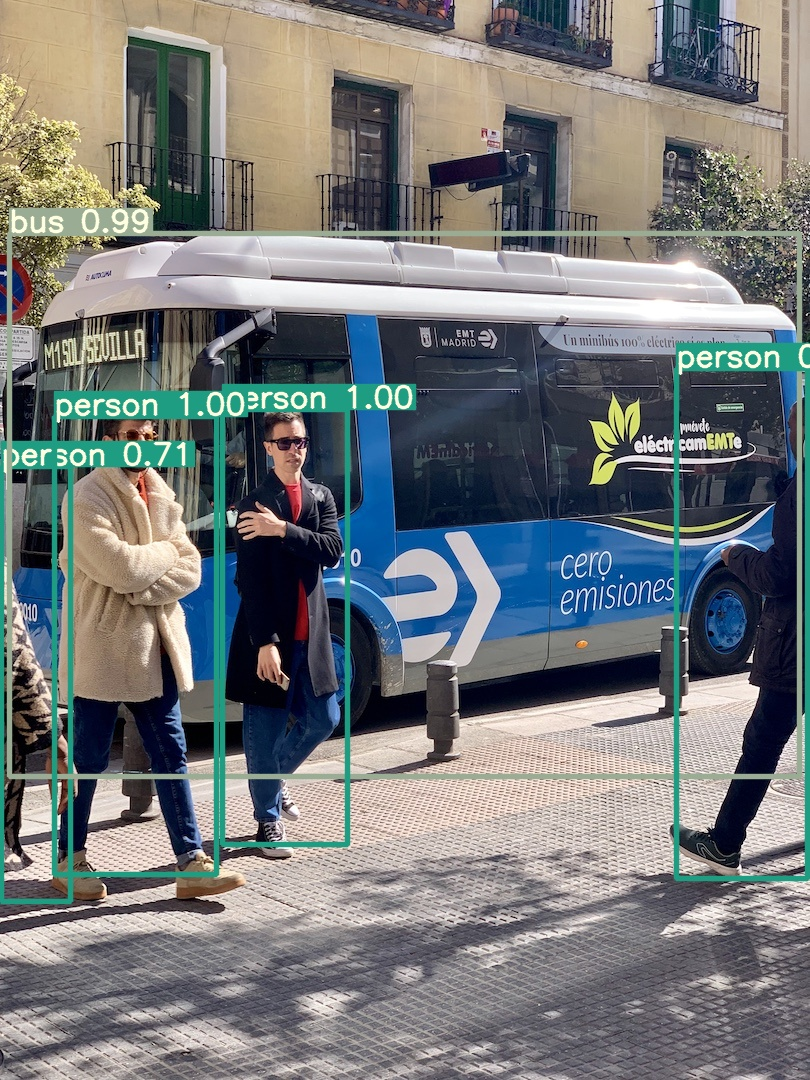

In [56]:
Image(filename ='output/bus.jpg', width = 600)

# Train

In [ ]:
!python3 train.py --data data/coco2017.data --imageSize 416 --epochs 300 --batch-size 8

In [ ]:
plotResults()

In [ ]:
Image(filename ='results.png', width = 800)

# Test

In [ ]:
!python3 test.py --data data/coco.data --imageSize 416  